In [3]:
%pylab inline
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import numba
import cupy as cp
from numba import cuda, prange
from numba.cuda import random
from numba import jit, njit, vectorize
import GPUtil

Populating the interactive namespace from numpy and matplotlib


C:\Users\mablab\AppData\Roaming\Python\Python38\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['vectorize', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# Functions
def ReLU(input):
    return input * (input > 0)


# Drift-Diffusion Model

## 1) CPU

<function matplotlib.pyplot.show(close=None, block=None)>

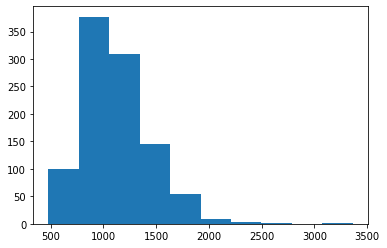

In [4]:
# DDM

# Variables
coh = 100
rt = np.array([],dtype=float32)       # Accumulator/decision variable
decision = np.array([],dtype=float32)       # Accumulator/decision variable

sp = 0             # starting point 1
dg = 10e-6         # drift gain
sigma = 10e-3      # diffusion variability
dr = coh*dg        # drift rate
t = 0              # time -> msec
ndt = 100          # Non-decision time (msec)
bound = 1
stop_time = 10000

nTrials = 1000

diffusion_step = np.random.normal(loc=dr, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 1
for tr in range(nTrials):
    dv = np.array([sp],dtype=float32)
    for t in range(stop_time):
        dv = np.append(dv, dv[t]+diffusion_step[tr,t])    # update decision variable
        if np.abs(dv[t]) > bound:    # checking if decision bound is reached
            decision =  np.append(decision, np.sign(dv[t]))
            rt =  np.append(rt, t)
            break
            
else:    # if decision is not reached
    decision =  np.append(decision, np.NaN)
    rt =  np.append(rt, np.NaN) 

    
rt = rt+ndt
    
# plt.plot(rt)
plt.hist(rt)
plt.show


## 2) CPU Parallelization with Numba

In [ ]:
# DDM_jit

# Variables
coh = 100
sp = 0             # starting point 1
dg = 10e-6         # drift gain
sigma = 10e-3      # diffusion variability
ndt = 100          # Non-decision time (msec)
bound = 1
pars = np.array([sp,dg,sigma,ndt,bound])
stop_time = 10000
nTrials = 50000

def DDM(coh,nTrials,pars,stop_time):
    # To create empty array for numba => [np.int64(x) for x in range(0)]
    rt =  np.empty(nTrials)*np.NaN         
    decision = np.empty(nTrials)*np.NaN        

    sp = pars[0]             # starting point 1
    dg = pars[1]             # drift gain
    sigma = pars[2]          # diffusion variability
    ndt = pars[3]            # Non-decision time (msec)
    bound = pars[4]
    dr = coh*dg              # drift rate
    t = 0                    # time -> msec
    
    diffusion_step = np.random.normal(loc=dr, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 1
    for tr in range(nTrials):
        dv = np.array([sp],dtype=float64)
        for t in range(stop_time):
            dv = np.append(dv, dv[t]+diffusion_step[tr,t])    # update decision variable
            if np.abs(dv[t]) > bound:    # checking if decision bound is reached
                decision[tr] =  np.sign(dv[t])
                rt[tr] = t
                break

    rt = rt+ndt
    return decision, rt


# In progress function
def DDM_numba(coh,nTrials,pars,stop_time):
    # To create empty array with numba => [np.int64(x) for x in range(0)]
    rt =  np.empty(nTrials)*np.NaN         
#     rt = rt[0]
    decision = np.empty(nTrials)*np.NaN        
#     decision = decision[0]

    sp = pars[0]             # starting point 1
    dg = pars[1]             # drift gain
    sigma = pars[2]          # diffusion variability
    ndt = pars[3]            # Non-decision time (msec)
    bound = pars[4]
    dr = coh*dg              # drift rate
    t = 0                    # time -> msec
    
    diffusion_step = np.random.normal(loc=dr, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 1
    for tr in prange(nTrials):
        dv = np.array([sp],dtype=float64)
        for t in range(stop_time):
            dv = np.append(dv, dv[t]+diffusion_step[tr,t])    # update decision variable
            if np.abs(dv[t]) > bound:    # checking if decision bound is reached
                decision[tr] =  np.sign(dv[t])
                rt[tr] = t
                break

    rt = rt+ndt
    return decision, rt


# DDM_jit = njit()(DDM)
# DDM_jit_parallel = njit(parallel=True,fastmath=True)(DDM)
DDM_jit_parallel_numba = njit(parallel=True,fastmath=True)(DDM_numba)

# %time decision, rt = DDM_jit(coh,nTrials,pars,stop_time)
# %time decision, rt = DDM_jit(coh,nTrials,pars,stop_time)

# %time decision, rt = DDM_jit_parallel(coh,nTrials,pars,stop_time)
# %time decision, rt = DDM_jit_parallel(coh,nTrials,pars,stop_time)

%time decision, rt = DDM_jit_parallel_numba(coh,nTrials,pars,stop_time)
%time decision, rt = DDM_jit_parallel_numba(coh,nTrials,pars,stop_time)

# plt.plot(rt)
# plt.hist(rt)
# plt.show

## 3) GPU Parallelization with Numba and CuPy

#### DDM Kernel for Numba

In [5]:
# # DDM Kernel
# def ddm_kernel(coh,nTrials,pars,stop_time,decision, rt):
#     tx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
#     ty = cuda.blockIdx.x  # Similarly, this is the unique block ID within the 1D grid

#     block_size = cuda.blockDim.x  # number of threads per block
#     grid_size = cuda.gridDim.x    # number of blocks in the grid
    
#     start = tx + ty * block_size
#     stride = block_size * grid_size

#     # assuming x and y inputs are same length
#     for i in range(start, x.shape[0], stride):
#         out[i] = x[i] + y[i]

# Working
@cuda.jit
def DDM_kernel(coh,nTrials,pars,stop_time,decision, rt, diffusion_step): 

    sp = pars[0]             # starting point 1
    dg = pars[1]             # drift gain
    sigma = pars[2]          # diffusion variability
    ndt = pars[3]            # Non-decision time (msec)
    bound = pars[4]
    dr = coh*dg              # drift rate
    t = 0                    # time -> msec

    tr = cuda.grid(1)
    tr_in_bounds = (tr >= 0) and (tr <= (nTrials - 1))
    
    if tr_in_bounds:
        dv = sp
        for t in range(stop_time):
            dv = dv + diffusion_step[tr,t]    # update decision variable
            if dv > bound or dv < -bound:    # checking if decision bound is reached
                decision[tr] =  2*(dv>0) - 1    #np.sign(dv) alternative
                rt[tr] = t+ndt
                break  
                
# With Coherence Matrix
@cuda.jit
def DDM_kernel2(sp, bound, ndt, diffusion_step, decision, rt): 
    tr = cuda.grid(1)
    tr_in_bounds = (tr >= 0) and (tr <= (diffusion_step.shape[0] - 1))   
    if tr_in_bounds:
        dv = sp
        for t in range(diffusion_step.shape[1]):
            dv = dv + diffusion_step[tr,t]    # update decision variable
            if dv > bound or dv < -bound:    # checking if decision bound is reached
                decision[tr] =  2*(dv>0) - 1    #np.sign(dv) alternative
                rt[tr] = t+ndt
                break  

# Matrix multiplication with LARGE matric and a scale or vector on GPU 
@cuda.jit
def matmult_cuda(matrix, scalar):
    row,col = cuda.grid(2)
    row_in_bounds = (row >= 0) and (row <= (matrix.shape[0] - 1))
    col_in_bounds = (col >= 0) and (col <= (matrix.shape[1] - 1))
    if row_in_bounds and col_in_bounds:
        matrix[row,col] = scalar*matrix[row,col]
# Initializing matmult_cuda function
test_mat = cp.array([[2,3,5],[4,5,5]],dtype=float32)
test_scalar = np.float32(3)
blockdim = (16, 16)
griddim = (test_mat.shape[0] // blockdim[0]) + 1, (test_mat.shape[1] // blockdim[1]) + 1
%time matmult_cuda[griddim, blockdim](test_mat, test_scalar)
        
                

In [ ]:
# Random Number generator for Coherence Matrix
cp.random.seed()
coh = 100
sp = 0             # starting point 1
dg = 10e-6         # drift gain
sigma = 10e-3      # diffusion variability
ndt = 100          # Non-decision time (msec)
bound = 1
dg = np.array([dg],dtype=float32)

# # Single Coherence Condition
# # Warm up JIT
# coh = cp.array([[100,100,50,50,50,100,100,100,50,0],[100,100,50,50,50,100,100,100,50,0]])
# diffusion_step = cp.random.normal(loc=coh*dg, scale=sigma, dtype = float32)    # change in accumulator 1
# decision_cp = cp.empty_like(diffusion_step[:,1])*cp.NaN
# rt_cp = cp.empty_like(diffusion_step[:,1])*cp.NaN
# blockdim = (16, 16)
# griddim = (coh.shape[0] // blockdim[0]) + 1
# DDM_kernel2[griddim, blockdim](sp, bound, ndt, diffusion_step, decision_cp, rt_cp)

stop_time = 10000
nTrials = 50000

!!! Problem !!! Too big matrix 
coh = np.ones((nTrials, stop_time), dtype=float32)*100
diffusion_step = cp.random.normal(loc=coh*dg, scale=sigma, dtype = float32)    # change in accumulator 1

decision_cp = cp.empty_like(diffusion_step[:,1])*cp.NaN
rt_cp = cp.empty_like(diffusion_step[:,1])*cp.NaN
blockdim = (16, 16)
griddim = (coh.shape[0] // blockdim[0]) + 1
cuda.synchronize()
%time DDM_kernel2[griddim, blockdim](sp, bound, ndt, diffusion_step, decision_cp, rt_cp)
cuda.synchronize()

# print(decision_cp, rt_cp)

# decision = cp.asnumpy(decision_cp)
# rt = cp.asnumpy(rt_cp)

## Work on separating coh matrix provided by experiment and creating some copy in GPU for drift rate

In [ ]:
# %time coh*dg
# %time np.multiply(coh,float(dg))

# buffer = np.empty_like(coh)
# %timeit np.multiply(float(dg), coh, buffer)

# coh2 = np.ones((nTrials, stop_time), dtype=float32)#*float(100)
# buffer = np.empty_like(coh2)
# %timeit np.multiply(np.float32(dg), coh2, buffer)
# # above is faster

# Maybe try vectorize
@vectorize#([float32(float32[:,:], float32)])
def matmult_numba(matrix, c):
    buffer = np.empty_like(matrix)
    return np.multiply(c[0], matrix, buffer)

%timeit matmult_numba(coh,dg)

In [27]:


# Here
if 'coh' in globals():
    del coh
cp.get_default_memory_pool().free_all_blocks()
stop_time = 10000
nTrials = 50000
dg = 10e-6         # drift gain
sigma = 10e-3      # diffusion variability
coh = np.ones((nTrials, stop_time), dtype=float32)*100


if 'diffusion_matrix' in globals():
    del diffusion_matrix
diffusion_matrix = cp.asarray(coh)
diffusion_matrix = cp.random.normal(diffusion_matrix, sigma, dtype='float32')
cp.get_default_memory_pool().free_all_blocks()
GPUtil.showUtilization()

In [ ]:
# Variables
cp.random.seed()
coh = 100
sp = 0             # starting point 1
dg = 10e-6         # drift gain
sigma = 10e-3      # diffusion variability
ndt = 100          # Non-decision time (msec)
bound = 1
pars = cp.asarray([sp,dg,sigma,ndt,bound])

# diffusion_step = cp.random.normal(loc=coh*dg, scale=sigma, size=(nTrials, stop_time), dtype = float32)    # change in accumulator 1
# diffusion_step_cp = cp.random.normal(loc=coh*dg, scale=sigma, size=(nTrials, stop_time), dtype = float32)    # change in accumulator 1
# decision_cp = cp.empty(nTrials)*cp.NaN
# rt_cp = cp.empty(nTrials)*cp.NaN
# # Warm up JIT
# stop_time = 10
# nTrials = 5
# decision_cp = cp.empty(nTrials)
# rt_cp = cp.empty(nTrials)
# blockdim = (16, 16)
# griddim = (nTrials // blockdim[0]) + 1
# ddm_kernel[griddim, blockdim](coh,nTrials,pars,stop_time,decision_cp, rt_cp, diffusion_step)

stop_time = 100000
nTrials = 50000
diffusion_step_cp = cp.random.normal(loc=coh*dg, scale=sigma, size=(nTrials, stop_time), dtype = float32)    # change in accumulator 1
decision_cp = cp.empty(nTrials)*cp.NaN
rt_cp = cp.empty(nTrials)*cp.NaN
blockdim = (16, 16)
griddim = (nTrials // blockdim[0]) + 1
cuda.synchronize()
%time ddm_kernel[griddim, blockdim](coh, nTrials, pars, stop_time, decision_cp, rt_cp, diffusion_step_cp)
cuda.synchronize()
print(decision_cp, rt_cp)

decision = cp.asnumpy(decision_cp)
rt = cp.asnumpy(rt_cp)

# Leaky-Competing Accumulator Model

In [ ]:
## LCA

# Variables
coh = 51

sp1 = 0             # starting point 1
sp2 = 0             # starting point 2
dg1 = 10e-6       # drift gain 1
dg2 = 2*10e-6       # drift gain 2
sigma = 10e-3         # diffusion variability
I0 = 0.001         # baseline input
dr1 = ReLU(coh)*dg1       # first variable (input)
dr2 = ReLU(-coh)*dg2       # second variable (input)
leak = 0               # leak
lateral_inhibition = 0               # lateral inhibition
t = 0               # time -> msec
ndt = 100           # Non-decision time (msec)
stop_time = 10000

nTrials = 1000
diffusion_step1 = np.random.normal(loc=dr1, scale=sigma, size=(nTrials, stop_time))
diffusion_step2 = np.random.normal(loc=dr2, scale=sigma, size=(nTrials, stop_time))
for tr in range(nTrials):
    dv1 = np.array([sp1],dtype=float32)       # Accumulator 1
    dv2 = np.array([sp2],dtype=float32)       # Accumulator 2
    for t in range(stop_time):
        del_dv1 = diffusion_step1[tr,t] - leak*dv1[t] - lateral_inhibition*dv2[t] + I0    # change in accumulator 1
        del_dv2 = diffusion_step2[tr,t] - leak*dv2[t] - lateral_inhibition*dv1[t] + I0    # change in accumulator 2
        dv1 = np.append(dv1, ReLU(dv1[t]+del_dv1))    # update decision variable 1
        dv2 = np.append(dv2, ReLU(dv2[t]+del_dv2))    # update decision variable 2
        if np.abs(dv1[t]) > bound:
            decision =  np.append(decision, 1)
            rt =  np.append(rt, t)
            break
        elif np.abs(dv2[t]) > bound:    # checking if decision bound is reached
            decision =  np.append(decision, -1)
            rt =  np.append(rt, t)
            break
            
else:    # if decision is not reached
    decision =  np.append(decision, np.NaN)
    rt =  np.append(rt, np.NaN) 
rt =  rt+ndt

# plt.plot(dv1,'b')
# plt.plot(dv2,'g')
plt.hist(rt)
plt.show


# Race Model

In [ ]:
# Race Model
''' 
Considering latent observation of the stimulus.
Mainly driven by diffusion variability (if considering 0 input in opposite direction)
Good estimate in case of motion energy in random dots also have some opposite direction motion.
'''

# Variables
coh = 52

sp1 = 0                   # starting point 1
sp2 = 0                   # starting point 2
dg1 = 10e-6               # drift gain 1
dg2 = 2*10e-6             # drift gain 2
sigma = 10e-3             # diffusion variability
I0 = 0.0002               # baseline input
dr1 = ReLU(coh)*dg1       # drift rate 1
dr2 = ReLU(-coh)*dg2      # drift rate 2
t = 0                     # time -> msec
ndt = 100                 # Non-decision time (msec)
stop_time = 10000

nTrials = 1000
diffusion_step1 = np.random.normal(loc=dr1, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 1
diffusion_step2 = np.random.normal(loc=dr2, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 2
for tr in range(nTrials):
    dv1 = np.array([sp1],dtype=float32)       # Accumulator 1
    dv2 = np.array([sp2],dtype=float32)       # Accumulator 2
    for t in range(stop_time):
        dv1 = np.append(dv1, ReLU(dv1[t]+diffusion_step1[tr,t]))    # update decision variable 1
        dv2 = np.append(dv2, ReLU(dv2[t]+diffusion_step2[tr,t]))    # update decision variable 2
        if np.abs(dv1[t]) > bound:
            decision =  np.append(decision, 1)
            rt =  np.append(rt, t)
            break
        elif np.abs(dv2[t]) > bound:    # checking if decision bound is reached
            decision =  np.append(decision, -1)
            rt =  np.append(rt, t)
            break
            
else:    # if decision is not reached
    decision =  np.append(decision, np.NaN)
    rt =  np.append(rt, np.NaN) 
rt =  rt+ndt

# plt.plot(dv1)
# plt.plot(dv2)
plt.hist(rt)
plt.show

# Latent Drift-Diffusion Model

In [ ]:
# Latent DDM
''' 
Considering latent observation of the stimulus.
Mainly driven by diffusion variability (if considering 0 input in opposite direction)
Good estimate in case of motion energy in random dots also have some opposite direction motion.

Mathematically equivalent to running DDM with diffusion of sqrt(2)*sigma instead of sigma

'''

# Variables
coh = 52

sp1 = 0                   # starting point 1
sp2 = 0                   # starting point 2
dg1 = 10e-6               # drift gain 1
dg2 = 2*10e-6             # drift gain 2
sigma = 10e-3             # diffusion variability
I0 = 0.0002               # baseline input
dr1 = ReLU(coh)*dg1       # drift rate 1
dr2 = ReLU(-coh)*dg2      # drift rate 2
t = 0                     # time -> msec
ndt = 100                 # Non-decision time (msec)
stop_time = 10000

nTrials = 1000
diffusion_step1 = np.random.normal(loc=dr1, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 1
diffusion_step2 = np.random.normal(loc=dr2, scale=sigma, size=(nTrials, stop_time))    # change in accumulator 2
for tr in range(nTrials):
    x1 = np.array([sp1],dtype=float32)       # Accumulator 1
    x2 = np.array([sp2],dtype=float32)       # Accumulator 2
    for t in range(stop_time):
        x1 = np.append(x1, x1[t]+diffusion_step1[tr,t])    # update decision variable 1
        x2 = np.append(x2, x2[t]+diffusion_step2[tr,t])    # update decision variable 2
        if np.abs(x1[t]-x2[t]) > bound:    # checking if decision bound is reached
            decision =  np.append(decision, np.sign(x1[t]-x2[t]))
            rt =  np.append(rt, t)
            break

else:    # if decision is not reached
    decision =  np.append(decision, np.NaN)
    rt =  np.append(rt, np.NaN) 
rt =  rt+ndt

# plt.plot(x1,'b')
# plt.plot(x2,'g')
# plt.plot(dv,'r')
plt.hist(rt)
plt.show